In [ ]:
#@title Block 1: Install Dependencies & Check GPU
import subprocess
import sys
import os

# Install packages
packages = [
    'transformers',
    'datasets',
    'tqdm',
    'tensorflow-hub',
    'pytesseract',
    'pillow',
]

for pkg in packages:
    print(f"Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Install Tesseract OCR engine
try:
    subprocess.check_call(['apt-get', 'update', '-qq'])
    subprocess.check_call(['apt-get', 'install', '-y', '-qq', 'tesseract-ocr'])
    print("Tesseract installed")
except:
    print("Could not install Tesseract via apt. Trying alternative")
    try:
        subprocess.check_call(['sudo', 'apt-get', 'install', '-y', 'tesseract-ocr'])
    except:
        print("Please install Tesseract manually: sudo apt-get install tesseract-ocr")

subprocess.check_call(['pip', 'install', '-q', 'tensorflow-text'])

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk
from tqdm.auto import tqdm
import json
import warnings
import time
import pickle
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# GPU Setup with Mixed Precision for 4070
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU Available: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision for faster training on RTX 4070
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    USE_GPU = True
else:
    print("\nNo GPU detected")
    USE_GPU = False

print(f"TensorFlow version: {tf.__version__}")
print(f"Num CPUs for OCR: {multiprocessing.cpu_count()}")

Installing transformers...
Installing datasets...
Installing tqdm...
Installing tensorflow-hub...
Installing pytesseract...
Installing pillow...
Tesseract installed

GPU Available: /physical_device:GPU:0
TensorFlow version: 2.19.0
Num CPUs for OCR: 4


In [ ]:
#@title Block 2: Load Dataset

DATASET_PATH = "/content/hf_datasets/RICO-ScreenQA-Short"

dataset = load_from_disk(DATASET_PATH)
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

print(f"\nDataset Summary: ")
print(f"  Train:      {len(train_dataset):,}")
print(f"  Validation: {len(val_dataset):,}")
print(f"  Test:       {len(test_dataset):,}")

print("\nFeatures:")
for feature in train_dataset.features:
    print(f"  - {feature}: {train_dataset.features[feature]}")

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]


Dataset Summary: 
  Train:      68,980
  Validation: 8,618
  Test:       8,427

Features:
  - screen_id: Value('string')
  - question: Value('string')
  - ground_truth: List(Value('string'))
  - file_name: Value('string')
  - image: Image(mode=None, decode=True)



Sample 1:
  Q: What is the default period length?...
  A: five days

Sample 2:
  Q: What is the default cycle length?...
  A: 30

Sample 3:
  Q: What is the start date of the last period?...
  A: Feb 10, 2017


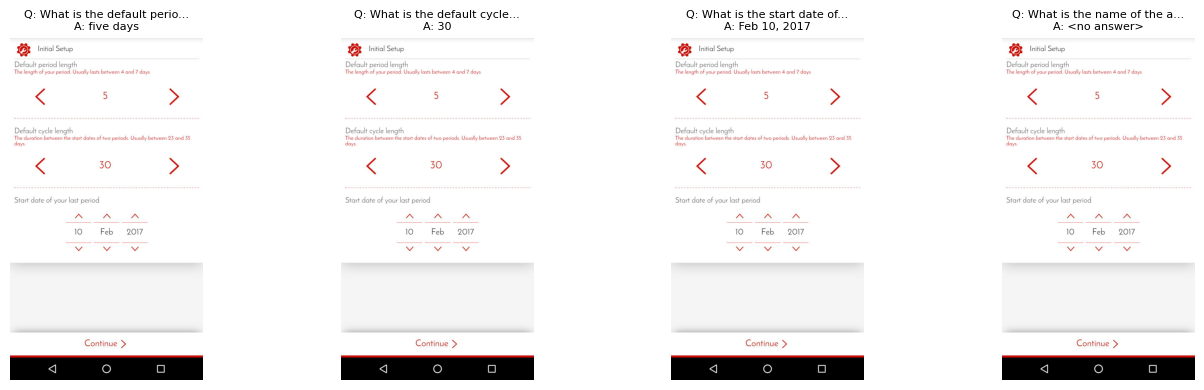

In [ ]:
#@title Block 3: Inspect Dataset & Show Examples

# Show 3 samples
for i in range(3):
    s = train_dataset[i]
    print(f"\nSample {i+1}:")
    print(f"  Q: {s['question'][:60]}...")
    print(f"  A: {s['ground_truth'][0]}")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for i, ax in enumerate(axes):
    s = train_dataset[i]
    ax.imshow(s['image'])
    ax.set_title(f"Q: {s['question'][:25]}...\nA: {s['ground_truth'][0][:15]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.savefig('/content/samples.png', dpi=150)
plt.show()

In [ ]:
#@title Block 4: Configuration

class Config:
    # Image
    IMAGE_SIZE = 224

    # ResNet + ViT
    RESNET_FEATURE_DIM = 2048 # Output 2048 channels
    RESNET_FEATURE_MAP_SIZE = 7
    VIT_EMBED_DIM = 256
    VIT_NUM_HEADS = 8
    VIT_MLP_DIM = 512
    VIT_NUM_LAYERS = 4
    VIT_DROPOUT = 0.1

    # BERT
    MAX_QUESTION_LENGTH = 128  # Increased for OCR text from 64

    # OCR Settings
    USE_OCR = True
    MAX_OCR_LENGTH = 200       # Max chars of OCR text to append
    OCR_WORKERS = 8            # Parallel OCR workers for fast data loading

    # Cross-attention
    CROSS_ATTN_HEADS = 8
    CROSS_ATTN_DIM = 256

    # Answer vocab
    MAX_VOCAB_SIZE = 5000

    # Training settings
    BATCH_SIZE = 48
    LEARNING_RATE = 3e-4
    EPOCHS = 10
    WARMUP_STEPS = 500
    LABEL_SMOOTHING = 0.1      # Helps generalization

    # Data
    TRAIN_SAMPLES = None       # None for all
    VAL_SAMPLES = None

    # Paths
    OCR_CACHE_PATH = '/content/ocr_cache.pkl'

    @classmethod
    def display(cls):
        print("\nConfig:")
        for attr in dir(cls):
            if not attr.startswith('_') and not callable(getattr(cls, attr)):
                print(f"  {attr}: {getattr(cls, attr)}")

Config.display()


Config:
  BATCH_SIZE: 48
  CROSS_ATTN_DIM: 256
  CROSS_ATTN_HEADS: 8
  EPOCHS: 10
  IMAGE_SIZE: 224
  LABEL_SMOOTHING: 0.1
  LEARNING_RATE: 0.0003
  MAX_OCR_LENGTH: 200
  MAX_QUESTION_LENGTH: 128
  MAX_VOCAB_SIZE: 5000
  OCR_CACHE_PATH: /content/ocr_cache.pkl
  OCR_WORKERS: 8
  RESNET_FEATURE_DIM: 2048
  RESNET_FEATURE_MAP_SIZE: 7
  TRAIN_SAMPLES: None
  USE_OCR: True
  VAL_SAMPLES: None
  VIT_DROPOUT: 0.1
  VIT_EMBED_DIM: 256
  VIT_MLP_DIM: 512
  VIT_NUM_HEADS: 8
  VIT_NUM_LAYERS: 4
  WARMUP_STEPS: 500


In [ ]:
#@title Block 5: FAST OCR Preprocessing (Tesseract + Multiprocessing)

import pytesseract
from PIL import Image
import tensorflow_hub as hub
import tensorflow_text

# Load BERT
BERT_MODEL_URL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2"
BERT_PREPROCESS_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess = hub.load(BERT_PREPROCESS_URL)
bert_encoder_hub = hub.load(BERT_MODEL_URL)
BERT_HIDDEN_SIZE = 256


# Fast OCR Function (Tesseract)
# Returns cleaned text string

def extract_ocr_text(image, max_length=Config.MAX_OCR_LENGTH):
    try:
        # Resize for speed (max 800px on longest side)
        img = image.convert('RGB')
        w, h = img.size
        max_dim = 800
        if max(w, h) > max_dim:
            scale = max_dim / max(w, h)
            img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)

        # Run Tesseract
        # PSM 6 = Assuming uniform block of text
        # OEM 3 = Default (LSTM + legacy)
        custom_config = r'--oem 3 --psm 6 -l eng'
        text = pytesseract.image_to_string(img, config=custom_config)

        # Clean text
        text = ' '.join(text.split())  # Remove extra whitespace
        text = ''.join(c for c in text if c.isalnum() or c.isspace())  # Keep alphanumeric
        text = text[:max_length]

        return text.strip()
    except Exception as e:
        return ""

# Process single sample for multiprocessing.
def process_single_sample(args):
    idx, image_bytes, screen_id = args
    try:
        img = Image.open(image_bytes)
        text = extract_ocr_text(img)
        return (screen_id, text)
    except:
        return (screen_id, "")


# Batch OCR with Multiprocessing
# Fast parallel OCR preprocessing
def precompute_ocr_parallel(dataset, cache_path, num_workers=8):
    # Check cache first
    if os.path.exists(cache_path):
        print(f"Loading cached OCR from {cache_path}")
        with open(cache_path, 'rb') as f:
            cache = pickle.load(f)
        print(f"Loaded {len(cache)} cached OCR results")
        return cache

    print(f"Running OCR on {len(dataset)} images.")
    cache = {}

    # Process in batches for memory efficiency
    batch_size = 500
    total_batches = (len(dataset) + batch_size - 1) // batch_size

    start_time = time.time()

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(dataset))

        batch_results = []
        for i in tqdm(range(start_idx, end_idx),
                      desc=f"Batch {batch_idx+1}/{total_batches}",
                      leave=False):
            sample = dataset[i]
            screen_id = sample['screen_id']
            text = extract_ocr_text(sample['image'])
            cache[screen_id] = text

        # Save checkpoint every batch
        with open(cache_path, 'wb') as f:
            pickle.dump(cache, f)

        elapsed = time.time() - start_time
        speed = len(cache) / elapsed
        eta = (len(dataset) - len(cache)) / speed if speed > 0 else 0
        print(f"  Processed {len(cache)}/{len(dataset)} | {speed:.1f} img/s | ETA: {eta/60:.1f} min")

    print(f"\nTotal time: {(time.time()-start_time)/60:.1f} minutes")
    return cache


# Build Answer Vocabulary
def build_vocab(dataset, max_size=5000):
    counts = {}
    for sample in tqdm(dataset, desc="Building vocab"):
        for ans in sample['ground_truth']:
            ans = ans.lower().strip()
            counts[ans] = counts.get(ans, 0) + 1

    sorted_ans = sorted(counts.items(), key=lambda x: -x[1])
    vocab = {'<pad>': 0, '<unk>': 1}
    for ans, _ in sorted_ans[:max_size - 2]:
        vocab[ans] = len(vocab)

    return vocab, {v: k for k, v in vocab.items()}

answer_vocab, inv_vocab = build_vocab(train_dataset, Config.MAX_VOCAB_SIZE)
NUM_ANSWERS = len(answer_vocab)
print(f"Vocabulary size: {NUM_ANSWERS}")


# Run OCR Preprocessing
if Config.USE_OCR:
    train_ocr = precompute_ocr_parallel(train_dataset, Config.OCR_CACHE_PATH)

    # Quick stats
    ocr_lengths = [len(t) for t in train_ocr.values()]
    non_empty = sum(1 for t in train_ocr.values() if t)
    print(f"\nOCR Stats:")
    print(f"Images with text: {non_empty}/{len(train_ocr)} ({100*non_empty/len(train_ocr):.1f}%)")
    print(f"Avg text length: {np.mean(ocr_lengths):.0f} chars")
else:
    train_ocr = {}
    print("OCR disabled")

# Preprocessing Functions
def preprocess_image(image):
    img = np.array(image.convert('RGB'))
    img = tf.image.resize(img, [Config.IMAGE_SIZE, Config.IMAGE_SIZE])
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

def preprocess_question(question, ocr_text=""):
    # Combine question with OCR (simple concatenation)
    if ocr_text and Config.USE_OCR:
        combined = f"{question} Context: {ocr_text}"
    else:
        combined = question

    combined = combined[:512]  # BERT max

    text_input = tf.constant([combined])
    tokenized = bert_preprocess(text_input)

    ids = tokenized['input_word_ids'].numpy()[0]
    mask = tokenized['input_mask'].numpy()[0]
    type_ids = tokenized['input_type_ids'].numpy()[0]

    max_len = Config.MAX_QUESTION_LENGTH

    # Pad or truncate
    if len(ids) > max_len:
        ids, mask, type_ids = ids[:max_len], mask[:max_len], type_ids[:max_len]
    else:
        pad = max_len - len(ids)
        ids = np.pad(ids, (0, pad))
        mask = np.pad(mask, (0, pad))
        type_ids = np.pad(type_ids, (0, pad))

    return ids.astype(np.int32), mask.astype(np.int32), type_ids.astype(np.int32)

# Encode answer to index
def encode_answer(gt_list):
    for ans in gt_list:
        ans = ans.lower().strip()
        if ans in answer_vocab:
            return answer_vocab[ans]
    return answer_vocab['<unk>']

# Decode index to answer.
def decode_answer(idx):
    return inv_vocab.get(idx, '<unk>')


# Create TF Dataset
def create_dataset(hf_dataset, ocr_cache, batch_size, shuffle=True, num_samples=None):
    if num_samples:
        hf_dataset = hf_dataset.select(range(min(num_samples, len(hf_dataset))))

    def gen():
        for sample in hf_dataset:
            img = preprocess_image(sample['image'])
            ocr = ocr_cache.get(sample['screen_id'], "") if ocr_cache else ""
            ids, mask, type_ids = preprocess_question(sample['question'], ocr)
            ans = encode_answer(sample['ground_truth'])

            yield {
                'image': img,
                'input_word_ids': ids,
                'input_mask': mask,
                'input_type_ids': type_ids
            }, ans

    output_sig = (
        {
            'image': tf.TensorSpec((Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), tf.float32),
            'input_word_ids': tf.TensorSpec((Config.MAX_QUESTION_LENGTH,), tf.int32),
            'input_mask': tf.TensorSpec((Config.MAX_QUESTION_LENGTH,), tf.int32),
            'input_type_ids': tf.TensorSpec((Config.MAX_QUESTION_LENGTH,), tf.int32),
        },
        tf.TensorSpec((), tf.int32)
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_sig)

    if shuffle:
        ds = ds.shuffle(2000)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

train_tf = create_dataset(train_dataset, train_ocr, Config.BATCH_SIZE, shuffle=True, num_samples=Config.TRAIN_SAMPLES)
val_tf = create_dataset(val_dataset, train_ocr, Config.BATCH_SIZE, shuffle=False, num_samples=Config.VAL_SAMPLES)

# Verify
for batch in train_tf.take(1):
    inputs, labels = batch
    print(f"\nBatch shapes:")
    print(f"Image: {inputs['image'].shape}")
    print(f"Word IDs: {inputs['input_word_ids'].shape}")
    print(f"Labels: {labels.shape}")

Building vocab:   0%|          | 0/68980 [00:00<?, ?it/s]

Vocabulary size: 5000
Loading cached OCR from /content/ocr_cache.pkl...
Loaded 28378 cached OCR results

OCR Stats:
Images with text: 28309/28378 (99.8%)
Avg text length: 141 chars

Batch shapes:
Image: (48, 224, 224, 3)
Word IDs: (48, 128)
Labels: (48,)


In [ ]:
#@title Block 6: Model Construction

# Patch embedding with positional encoding.
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_patches, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.proj = tf.keras.layers.Dense(embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(num_patches + 1, embed_dim)

    def build(self, input_shape):
        self.cls = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.embed_dim),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        B = tf.shape(x)[0]
        x = self.proj(x)
        cls = tf.broadcast_to(self.cls, [B, 1, self.embed_dim])
        x = tf.concat([cls, x], axis=1)
        pos = tf.range(self.num_patches + 1)
        x = x + self.pos_emb(pos)
        return x

# Transformer encoder block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attn = tf.keras.layers.MultiHeadAttention(
            num_heads=heads,
            key_dim=dim // heads,
            dropout=dropout
        )
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation='gelu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(dim),
            tf.keras.layers.Dropout(dropout)
        ])
        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()
        self.drop = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        attn_out = self.attn(x, x, training=training)
        x = self.ln1(x + self.drop(attn_out, training=training))
        mlp_out = self.mlp(x, training=training)
        x = self.ln2(x + mlp_out)
        return x

# ResNet50 + ViT visual encoder
class VisualEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, heads, mlp_dim, layers, dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        self.resnet = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3)
        )
        # Freeze most of ResNet
        for layer in self.resnet.layers[:-30]:
            layer.trainable = False

        self.num_patches = Config.RESNET_FEATURE_MAP_SIZE ** 2
        self.patch_emb = PatchEmbedding(dim, self.num_patches)
        self.blocks = [TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(layers)]
        self.ln = tf.keras.layers.LayerNormalization()

    def call(self, x, training=False):
        # Cast to float32 for ResNet (mixed precision compatibility)
        x = tf.cast(x, tf.float32)
        x = self.resnet(x, training=training)
        B = tf.shape(x)[0]
        x = tf.reshape(x, [B, -1, Config.RESNET_FEATURE_DIM])
        x = self.patch_emb(x)
        for block in self.blocks:
            x = block(x, training=training)
        return self.ln(x)

# BERT text encoder
class TextEncoder(tf.keras.layers.Layer):
    def __init__(self, output_dim, bert_url, **kwargs):
        super().__init__(**kwargs)
        self.bert = hub.KerasLayer(bert_url, trainable=False)
        self.proj = tf.keras.layers.Dense(output_dim)
        self.ln = tf.keras.layers.LayerNormalization()

    def call(self, word_ids, mask, type_ids, training=False):
        # Cast inputs to int32 for BERT
        word_ids = tf.cast(word_ids, tf.int32)
        mask = tf.cast(mask, tf.int32)
        type_ids = tf.cast(type_ids, tf.int32)

        out = self.bert({
            'input_word_ids': word_ids,
            'input_mask': mask,
            'input_type_ids': type_ids
        })
        x = self.proj(out['sequence_output'])
        return self.ln(x)

# Cross-attention layer
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, dim, heads, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attn = tf.keras.layers.MultiHeadAttention(
            num_heads=heads,
            key_dim=dim // heads,
            dropout=dropout
        )
        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(dim * 4, activation='gelu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(dim),
            tf.keras.layers.Dropout(dropout)
        ])

    def call(self, q, kv, training=False):
        attn_out = self.attn(q, kv, training=training)
        x = self.ln1(q + attn_out)
        mlp_out = self.mlp(x, training=training)
        return self.ln2(x + mlp_out)



# Main VLM Model
class VLMModel(tf.keras.Model):
    def __init__(self, num_answers, bert_url, **kwargs):
        super().__init__(**kwargs)

        dim = Config.VIT_EMBED_DIM

        self.visual_enc = VisualEncoder(
            dim, Config.VIT_NUM_HEADS, Config.VIT_MLP_DIM,
            Config.VIT_NUM_LAYERS, Config.VIT_DROPOUT
        )

        self.text_enc = TextEncoder(dim, bert_url)

        # Multi-layer cross attention
        self.cross_attn1 = CrossAttention(dim, Config.CROSS_ATTN_HEADS)
        self.cross_attn2 = CrossAttention(dim, Config.CROSS_ATTN_HEADS)

        # Classifier with regularization
        self.fusion = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='gelu',
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation='gelu',
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.Dropout(0.2),
        ])

        # Output layer - use float32 for numerical stability with mixed precision
        self.classifier = tf.keras.layers.Dense(num_answers, dtype='float32')

    def call(self, inputs, training=False):
        # Encode visual
        vis = self.visual_enc(inputs['image'], training=training)

        # Encode text
        txt = self.text_enc(
            inputs['input_word_ids'],
            inputs['input_mask'],
            inputs['input_type_ids'],
            training=training
        )

        # Cross attention (text attends to visual)
        fused = self.cross_attn1(txt, vis, training=training)
        fused = self.cross_attn2(fused, vis, training=training)

        # Pool and classify
        txt_cls = fused[:, 0, :]
        vis_cls = vis[:, 0, :]
        combined = tf.concat([txt_cls, vis_cls], axis=-1)

        # Cast to float32 for classifier (mixed precision)
        combined = tf.cast(combined, tf.float32)
        x = self.fusion(combined, training=training)
        return self.classifier(x)


# Build Model
model = VLMModel(NUM_ANSWERS, BERT_MODEL_URL)

# Build with dummy input
dummy = {
    'image': tf.zeros((1, Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=tf.float32),
    'input_word_ids': tf.zeros((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_mask': tf.ones((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_type_ids': tf.zeros((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
}
_ = model(dummy, training=False)

# Count params
total_params = sum(np.prod(v.shape) for v in model.trainable_variables)
print(f"\nModel built successfully")
print(f"Trainable parameters: {total_params:,}")
print(f" Answer classes: {NUM_ANSWERS}")


Model built successfully
Trainable parameters: 20,421,512
 Answer classes: 5000



Training setup:
  Samples: 68,980
  Batch size: 48
  Steps/epoch: 1437
  Total epochs: 10
  Learning rate: 5e-05 (reduced for stability)

Epoch 1/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=5.2169 Acc=0.3679 Top5=0.4967
  Val:   Loss=4.3129 Acc=0.4110 Top5=0.5690
New best: 0.4110 (41.10%)

Epoch 2/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=4.3817 Acc=0.3953 Top5=0.5669
  Val:   Loss=4.1479 Acc=0.4109 Top5=0.5904
Patience: 1/5

Epoch 3/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=4.1336 Acc=0.4040 Top5=0.5815
  Val:   Loss=4.0631 Acc=0.4045 Top5=0.5967
Patience: 2/5

Epoch 4/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.9085 Acc=0.4163 Top5=0.5936
  Val:   Loss=3.9890 Acc=0.4073 Top5=0.6045
Patience: 3/5

Epoch 5/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.7145 Acc=0.4288 Top5=0.6047
  Val:   Loss=3.9741 Acc=0.4139 Top5=0.6104
New best: 0.4139 (41.39%)

Epoch 6/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.5423 Acc=0.4427 Top5=0.6147
  Val:   Loss=4.0372 Acc=0.3896 Top5=0.6086
Patience: 1/5

Epoch 7/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.3957 Acc=0.4561 Top5=0.6228
  Val:   Loss=4.0634 Acc=0.3980 Top5=0.6104
Patience: 2/5

Epoch 8/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.2878 Acc=0.4667 Top5=0.6281
  Val:   Loss=4.1139 Acc=0.3955 Top5=0.6088
Patience: 3/5

Epoch 9/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.2273 Acc=0.4765 Top5=0.6316
  Val:   Loss=4.1389 Acc=0.3936 Top5=0.6073
Patience: 4/5

Epoch 10/10


Train:   0%|          | 0/1437 [00:00<?, ?it/s]

Val: 0it [00:00, ?it/s]


  Train: Loss=3.2217 Acc=0.4808 Top5=0.6333
  Val:   Loss=4.1355 Acc=0.3941 Top5=0.6035
Patience: 5/5

Early stopping at epoch 10
  Time: 262.5 minutes
  Best Val Acc: 0.4139 (41.39%)


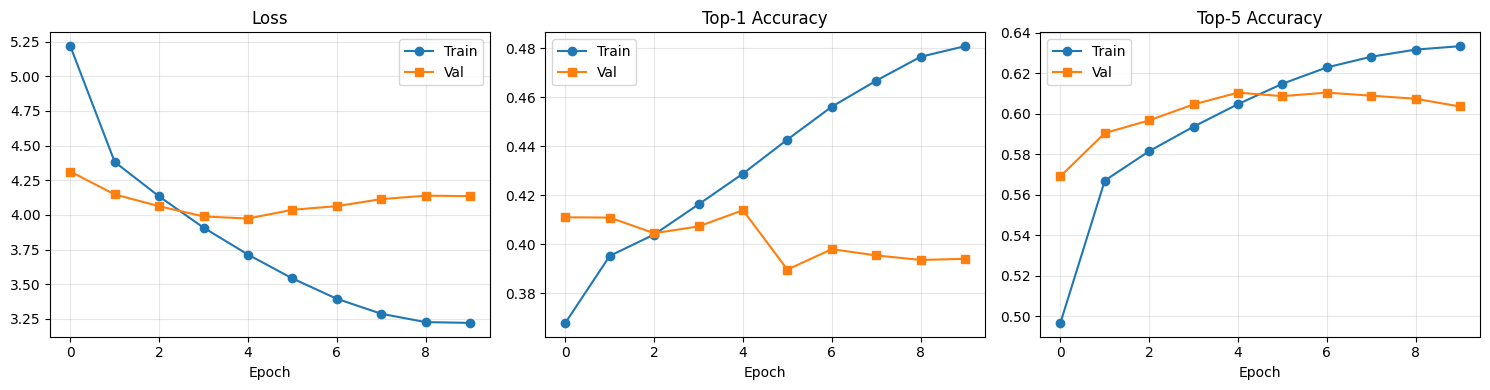

In [ ]:
#@title Block 7: Training Setup & Training Loop

tf.keras.mixed_precision.set_global_policy('float32')

# Learning Rate Schedule (Lower LR)
class WarmupCosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, total_steps):
        self.base_lr = base_lr
        self.warmup_steps = float(warmup_steps)
        self.total_steps = float(total_steps)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        # Warmup
        warmup_lr = self.base_lr * (step / self.warmup_steps)
        # Cosine decay
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps + 1e-6)
        progress = tf.minimum(progress, 1.0)
        decay_lr = self.base_lr * 0.5 * (1.0 + tf.cos(np.pi * progress))
        return tf.where(step < self.warmup_steps, warmup_lr, decay_lr)

    def get_config(self):
        return {'base_lr': self.base_lr, 'warmup_steps': self.warmup_steps, 'total_steps': self.total_steps}


# Setup Training (Lower LR for stability)
train_size = Config.TRAIN_SAMPLES if Config.TRAIN_SAMPLES else len(train_dataset)
steps_per_epoch = train_size // Config.BATCH_SIZE
total_steps = steps_per_epoch * Config.EPOCHS

# Lower learning rate to prevent NaN
LEARNING_RATE = 5e-5

print(f"\nTraining setup:")
print(f"  Samples: {train_size:,}")
print(f"  Batch size: {Config.BATCH_SIZE}")
print(f"  Steps/epoch: {steps_per_epoch}")
print(f"  Total epochs: {Config.EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE} (reduced for stability)")

lr_schedule = WarmupCosineSchedule(LEARNING_RATE, Config.WARMUP_STEPS, total_steps)

# Use standard Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=0.5)

# Stable Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compute loss with NaN checking
def compute_loss(labels, logits):
    # Clip logits to prevent overflow
    logits = tf.clip_by_value(logits, -50.0, 50.0)
    loss = loss_fn(labels, logits)
    # Replace NaN with 0 (skip bad batches)
    loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)
    return loss


# Metrics
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
train_top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
val_loss = tf.keras.metrics.Mean()
val_acc = tf.keras.metrics.SparseCategoricalAccuracy()
val_top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)


# Training Steps
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        loss = compute_loss(labels, logits)

    # Check for NaN loss
    if tf.math.is_nan(loss):
        return loss  # Skip update if NaN

    grads = tape.gradient(loss, model.trainable_variables)

    # Check for NaN gradients
    grads = [tf.where(tf.math.is_nan(g), tf.zeros_like(g), g) for g in grads]

    # Clip gradients (more aggressive)
    grads, grad_norm = tf.clip_by_global_norm(grads, 0.5)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss.update_state(loss)
    train_acc.update_state(labels, logits)
    train_top5.update_state(labels, logits)

    return loss

@tf.function
def val_step(inputs, labels):
    logits = model(inputs, training=False)
    logits = tf.clip_by_value(logits, -50.0, 50.0)
    loss = loss_fn(labels, logits)

    val_loss.update_state(loss)
    val_acc.update_state(labels, logits)
    val_top5.update_state(labels, logits)

# Delete old model
del model

# Rebuild
model = VLMModel(NUM_ANSWERS, BERT_MODEL_URL)

# Build with dummy input
dummy = {
    'image': tf.zeros((1, Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=tf.float32),
    'input_word_ids': tf.zeros((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_mask': tf.ones((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_type_ids': tf.zeros((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
}
_ = model(dummy, training=False)


# Training Loop
history = {'train_loss': [], 'train_acc': [], 'train_top5': [],
           'val_loss': [], 'val_acc': [], 'val_top5': []}

best_val_acc = 0.0
patience = 5  # More patience
patience_count = 0
nan_count = 0  # Track NaN occurrences


start_time = time.time()

for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
    # Reset
    train_loss.reset_state()
    train_acc.reset_state()
    train_top5.reset_state()
    val_loss.reset_state()
    val_acc.reset_state()
    val_top5.reset_state()
    epoch_nan_count = 0

    # Train
    pbar = tqdm(train_tf, desc="Train", total=steps_per_epoch)
    for i, (inputs, labels) in enumerate(pbar):
        loss = train_step(inputs, labels)

        # Check for NaN
        if tf.math.is_nan(loss):
            epoch_nan_count += 1
            continue  # Skip this batch

        # Get current metrics
        current_loss = float(train_loss.result())
        current_acc = float(train_acc.result())
        current_top5 = float(train_top5.result())

        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}',
            'top5': f'{current_top5:.4f}'
        })

        if Config.TRAIN_SAMPLES and i >= steps_per_epoch:
            break

    if epoch_nan_count > 0:
        print(f"{epoch_nan_count} NaN batches skipped")

    # Check if training collapsed
    if float(train_loss.result()) == 0 or np.isnan(float(train_loss.result())):
        print(" Training collapsed")
        break

    # Validate
    pbar = tqdm(val_tf, desc="Val")
    for i, (inputs, labels) in enumerate(pbar):
        val_step(inputs, labels)

        current_loss = float(val_loss.result())
        current_acc = float(val_acc.result())
        current_top5 = float(val_top5.result())

        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}',
            'top5': f'{current_top5:.4f}'
        })

        if Config.VAL_SAMPLES and i >= Config.VAL_SAMPLES // Config.BATCH_SIZE:
            break

    # Record
    t_loss = float(train_loss.result())
    t_acc = float(train_acc.result())
    t_top5 = float(train_top5.result())
    v_loss = float(val_loss.result())
    v_acc = float(val_acc.result())
    v_top5 = float(val_top5.result())

    history['train_loss'].append(t_loss if not np.isnan(t_loss) else 0)
    history['train_acc'].append(t_acc)
    history['train_top5'].append(t_top5)
    history['val_loss'].append(v_loss if not np.isnan(v_loss) else 0)
    history['val_acc'].append(v_acc)
    history['val_top5'].append(v_top5)

    print(f"\n  Train: Loss={t_loss:.4f} Acc={t_acc:.4f} Top5={t_top5:.4f}")
    print(f"  Val:   Loss={v_loss:.4f} Acc={v_acc:.4f} Top5={v_top5:.4f}")

    # Save best
    if v_acc > best_val_acc:
        best_val_acc = v_acc
        patience_count = 0
        model.save_weights('/content/best_model.weights.h5')
        print(f"New best: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    else:
        patience_count += 1
        print(f"Patience: {patience_count}/{patience}")
        if patience_count >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

elapsed = time.time() - start_time
print(f"  Time: {elapsed/60:.1f} minutes")
print(f"  Best Val Acc: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

# Plot History
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Val', marker='s')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Val', marker='s')
axes[1].set_title('Top-1 Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['train_top5'], label='Train', marker='o')
axes[2].plot(history['val_top5'], label='Val', marker='s')
axes[2].set_title('Top-5 Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training.png', dpi=150)
plt.show()

with open('/content/history.json', 'w') as f:
    json.dump(history, f)

In [ ]:
#@title BLOCK 8: Model Summary

# Shape analysis
sample = {
    'image': tf.random.normal((2, Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3)),
    'input_word_ids': tf.zeros((2, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_mask': tf.ones((2, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_type_ids': tf.zeros((2, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
}

print("\nShape Flow:")
print(f"  Input Image:    {sample['image'].shape}")
print(f"  Input Text:     {sample['input_word_ids'].shape}")

vis = model.visual_enc(sample['image'])
txt = model.text_enc(sample['input_word_ids'], sample['input_mask'], sample['input_type_ids'])
print(f"  Visual Features: {vis.shape}")
print(f"  Text Features:   {txt.shape}")

out = model(sample)
print(f"  Output Logits:   {out.shape}")


Shape Flow:
  Input Image:    (2, 224, 224, 3)
  Input Text:     (2, 128)
  Visual Features: (2, 50, 256)
  Text Features:   (2, 128, 256)
  Output Logits:   (2, 5000)


Loaded 3489 test OCR results

Evaluating on 500 samples


Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]


Top-1 Accuracy: 5.20%
Top-5 Accuracy: 24.80%


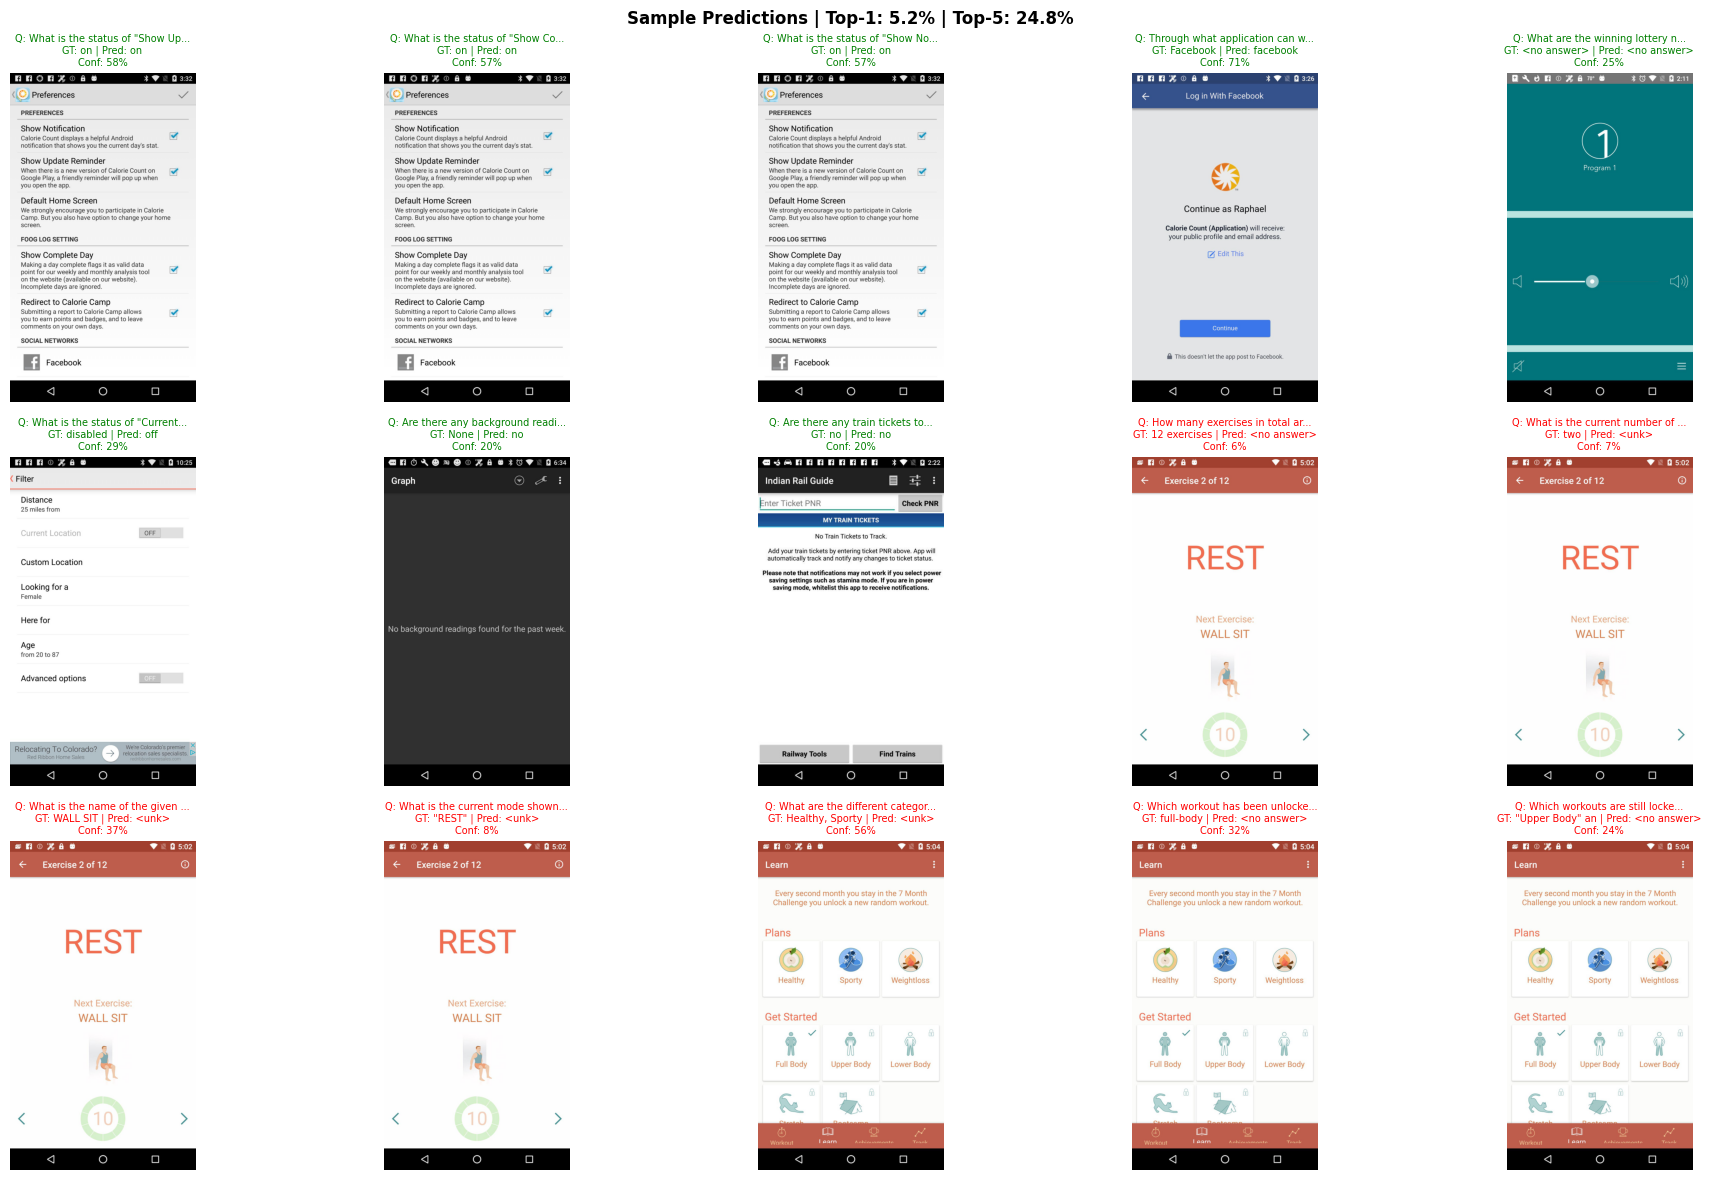


Saved results to /content/results.csv


In [ ]:
#@title BLOCK 9: Evaluation


from collections import defaultdict, Counter
import pandas as pd

# Load best weights
if os.path.exists('/content/best_model.weights.h5'):
    model.load_weights('/content/best_model.weights.h5')

# Precompute Test OCR
TEST_OCR_PATH = '/content/test_ocr.pkl'

if Config.USE_OCR:
    if os.path.exists(TEST_OCR_PATH):
        with open(TEST_OCR_PATH, 'rb') as f:
            test_ocr = pickle.load(f)
        print(f"Loaded {len(test_ocr)} test OCR results")
    else:
        print("Computing test OCR")
        test_ocr = {}
        for i, sample in enumerate(tqdm(test_dataset, desc="Test OCR")):
            test_ocr[sample['screen_id']] = extract_ocr_text(sample['image'])
        with open(TEST_OCR_PATH, 'wb') as f:
            pickle.dump(test_ocr, f)
else:
    test_ocr = {}


# Inference Function
def predict(image, question, ocr_text="", top_k=5):
    img = preprocess_image(image)
    img = tf.expand_dims(img, 0)

    ids, mask, type_ids = preprocess_question(question, ocr_text)
    ids = tf.expand_dims(ids, 0)
    mask = tf.expand_dims(mask, 0)
    type_ids = tf.expand_dims(type_ids, 0)

    inputs = {'image': img, 'input_word_ids': ids, 'input_mask': mask, 'input_type_ids': type_ids}
    logits = model(inputs, training=False)
    probs = tf.nn.softmax(logits, axis=-1)[0]

    top_vals, top_idx = tf.math.top_k(probs, k=top_k)

    preds = []
    for i in range(top_k):
        preds.append({
            'answer': decode_answer(top_idx[i].numpy()),
            'conf': float(top_vals[i].numpy())
        })

    return preds

# Check if prediction is correct
def check_correct(pred, gt_list):
    p = pred.lower().strip()
    return any(p == g.lower().strip() for g in gt_list)


def classify_q(q):
    q = q.lower()
    if 'how many' in q or 'count' in q:
        return 'Counting'
    elif 'what text' in q or 'what does it say' in q or 'written' in q:
        return 'Text'
    elif 'what color' in q:
        return 'Color'
    elif 'where' in q or 'location' in q:
        return 'Location'
    elif 'is there' in q or 'are there' in q:
        return 'Yes/No'
    elif 'what is' in q:
        return 'WhatIs'
    return 'Other'

# Run Evaluation
NUM_TEST = min(500, len(test_dataset))
print(f"\nEvaluating on {NUM_TEST} samples")

results = []
q_stats = defaultdict(lambda: {'total': 0, 'top1': 0, 'top5': 0})
ocr_stats = {'with': {'n': 0, 'correct': 0}, 'without': {'n': 0, 'correct': 0}}

for i in tqdm(range(NUM_TEST), desc="Evaluating"):
    sample = test_dataset[i]
    ocr = test_ocr.get(sample['screen_id'], "") if Config.USE_OCR else ""

    preds = predict(sample['image'], sample['question'], ocr)

    top1_correct = check_correct(preds[0]['answer'], sample['ground_truth'])
    top5_correct = any(check_correct(p['answer'], sample['ground_truth']) for p in preds[:5])

    q_type = classify_q(sample['question'])
    q_stats[q_type]['total'] += 1
    if top1_correct:
        q_stats[q_type]['top1'] += 1
    if top5_correct:
        q_stats[q_type]['top5'] += 1

    key = 'with' if ocr else 'without'
    ocr_stats[key]['n'] += 1
    if top1_correct:
        ocr_stats[key]['correct'] += 1

    results.append({
        'idx': i,
        'question': sample['question'],
        'q_type': q_type,
        'gt': sample['ground_truth'][0],
        'pred': preds[0]['answer'],
        'conf': preds[0]['conf'],
        'top1': top1_correct,
        'top5': top5_correct,
        'ocr_len': len(ocr),
        'image': sample['image']
    })


# Results
top1 = sum(r['top1'] for r in results) / NUM_TEST * 100
top5 = sum(r['top5'] for r in results) / NUM_TEST * 100


print(f"\nTop-1 Accuracy: {top1:.2f}%")
print(f"Top-5 Accuracy: {top5:.2f}%")

# Sample Predictions
fig2, axes2 = plt.subplots(3, 5, figsize=(20, 12))
axes2 = axes2.flatten()

correct_ex = [r for r in results if r['top1']][:8]
incorrect_ex = [r for r in results if not r['top1']][:7]
examples = correct_ex + incorrect_ex

for i, ex in enumerate(examples[:15]):
    ax = axes2[i]
    ax.imshow(ex['image'])
    color = 'green' if ex['top1'] else 'red'
    ax.set_title(f"Q: {ex['question'][:30]}...\nGT: {ex['gt'][:15]} | Pred: {ex['pred'][:15]}\nConf: {ex['conf']*100:.0f}%",
                fontsize=7, color=color)
    ax.axis('off')


plt.suptitle(f'Sample Predictions | Top-1: {top1:.1f}% | Top-5: {top5:.1f}%', fontweight='bold')
plt.tight_layout()
plt.savefig('/content/samples_eval.png', dpi=150)
plt.show()


# Save Results
df = pd.DataFrame([{
    'Q': r['question'][:40], 'Type': r['q_type'], 'GT': r['gt'][:20],
    'Pred': r['pred'][:20], 'Conf': f"{r['conf']*100:.0f}%", 'Correct': '✓' if r['top1'] else '✗'
} for r in results])
df.to_csv('/content/results.csv', index=False)

print("\nSaved results to /content/results.csv")